In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Unabbreviating columns 

In [3]:
df= pd.read_csv(r'/content/drive/My Drive/Work/Datasets/Kidney/kidney_disease.csv')

In [4]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [5]:
columns= pd.read_csv('/content/drive/My Drive/Work/Datasets/Kidney/data_description.txt', sep='-')
columns= columns.reset_index()

In [6]:
columns.columns= ['cols', 'abb_col_names']
columns

,cols,abb_col_names
0,id,id
1,age,age
2,bp,blood pressure
3,sg,specific gravity
4,al,albumin
5,su,sugar
6,rbc,red blood cells
7,pc,pus cell
8,pcc,pus cell clumps
9,ba,bacteria


In [7]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [8]:
df.columns= columns['abb_col_names'].values

In [9]:
df.head()

,id,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,serum creatinine,sodium,potassium,haemoglobin,packed cell volume,white blood cell count,red blood cell count,ypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,class
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [10]:
df.dtypes

id                           int64
age                        float64
blood pressure             float64
specific gravity           float64
albumin                    float64
sugar                      float64
red blood cells             object
 pus cell                   object
pus cell clumps             object
bacteria                    object
blood glucose random       float64
blood urea                 float64
serum creatinine           float64
sodium                     float64
potassium                  float64
haemoglobin                float64
packed cell volume          object
white blood cell count      object
red blood cell count        object
ypertension                 object
diabetes mellitus           object
coronary artery disease     object
appetite                    object
pedal edema                 object
anemia                      object
class                       object
dtype: object

In [11]:
def convert_dtype(df, feature):
  df[feature]= pd.to_numeric(df[feature], errors= 'coerce')

In [12]:
features= ['packed cell volume', 'white blood cell count', 'red blood cell count']
for feature in features:
  convert_dtype(df, feature)

In [13]:
df.dtypes

id                           int64
age                        float64
blood pressure             float64
specific gravity           float64
albumin                    float64
sugar                      float64
red blood cells             object
 pus cell                   object
pus cell clumps             object
bacteria                    object
blood glucose random       float64
blood urea                 float64
serum creatinine           float64
sodium                     float64
potassium                  float64
haemoglobin                float64
packed cell volume         float64
white blood cell count     float64
red blood cell count       float64
ypertension                 object
diabetes mellitus           object
coronary artery disease     object
appetite                    object
pedal edema                 object
anemia                      object
class                       object
dtype: object

In [14]:
df.drop('id', axis= 1, inplace=True)

# Data Cleaning

In [15]:
def extract_cat_num(df):
  cat_col= [col for col in df.columns if df[col].dtype== 'object']
  num_col= [col for col in df.columns if df[col].dtype!= 'object']
  return cat_col, num_col

In [16]:
cat_col, num_col= extract_cat_num(df)
cat_col

['red blood cells',
 ' pus cell',
 'pus cell clumps',
 'bacteria',
 'ypertension',
 'diabetes mellitus',
 'coronary artery disease',
 'appetite',
 'pedal edema',
 'anemia',
 'class']

In [17]:
num_col

['age',
 'blood pressure',
 'specific gravity',
 'albumin',
 'sugar',
 'blood glucose random',
 'blood urea',
 'serum creatinine',
 'sodium',
 'potassium',
 'haemoglobin',
 'packed cell volume',
 'white blood cell count',
 'red blood cell count']

In [18]:
for col in cat_col:
  print('{} has {} values'.format(col, df[col].unique()))
  print('\n')

red blood cells has [nan 'normal' 'abnormal'] values


 pus cell has ['normal' 'abnormal' nan] values


pus cell clumps has ['notpresent' 'present' nan] values


bacteria has ['notpresent' 'present' nan] values


ypertension has ['yes' 'no' nan] values


diabetes mellitus has ['yes' 'no' ' yes' '\tno' '\tyes' nan] values


coronary artery disease has ['no' 'yes' '\tno' nan] values


appetite has ['good' 'poor' nan] values


pedal edema has ['no' 'yes' nan] values


anemia has ['no' 'yes' nan] values


class has ['ckd' 'ckd\t' 'notckd'] values




In [19]:
df['diabetes mellitus'].replace(to_replace= {'\tno': 'no','\tyes': 'yes'}, inplace=True)
df['coronary artery disease'].replace(to_replace= {'\tno': 'no','\tyes': 'yes'}, inplace=True)
df['class'].replace(to_replace= { 'ckd\t': 'ckd'}, inplace=True)

In [20]:
for col in cat_col:
  print('{} has {} values'.format(col, df[col].unique()))
  print('\n')

red blood cells has [nan 'normal' 'abnormal'] values


 pus cell has ['normal' 'abnormal' nan] values


pus cell clumps has ['notpresent' 'present' nan] values


bacteria has ['notpresent' 'present' nan] values


ypertension has ['yes' 'no' nan] values


diabetes mellitus has ['yes' 'no' ' yes' nan] values


coronary artery disease has ['no' 'yes' nan] values


appetite has ['good' 'poor' nan] values


pedal edema has ['no' 'yes' nan] values


anemia has ['no' 'yes' nan] values


class has ['ckd' 'notckd'] values




# Analyzing Distributions

In [21]:
len(num_col)

14

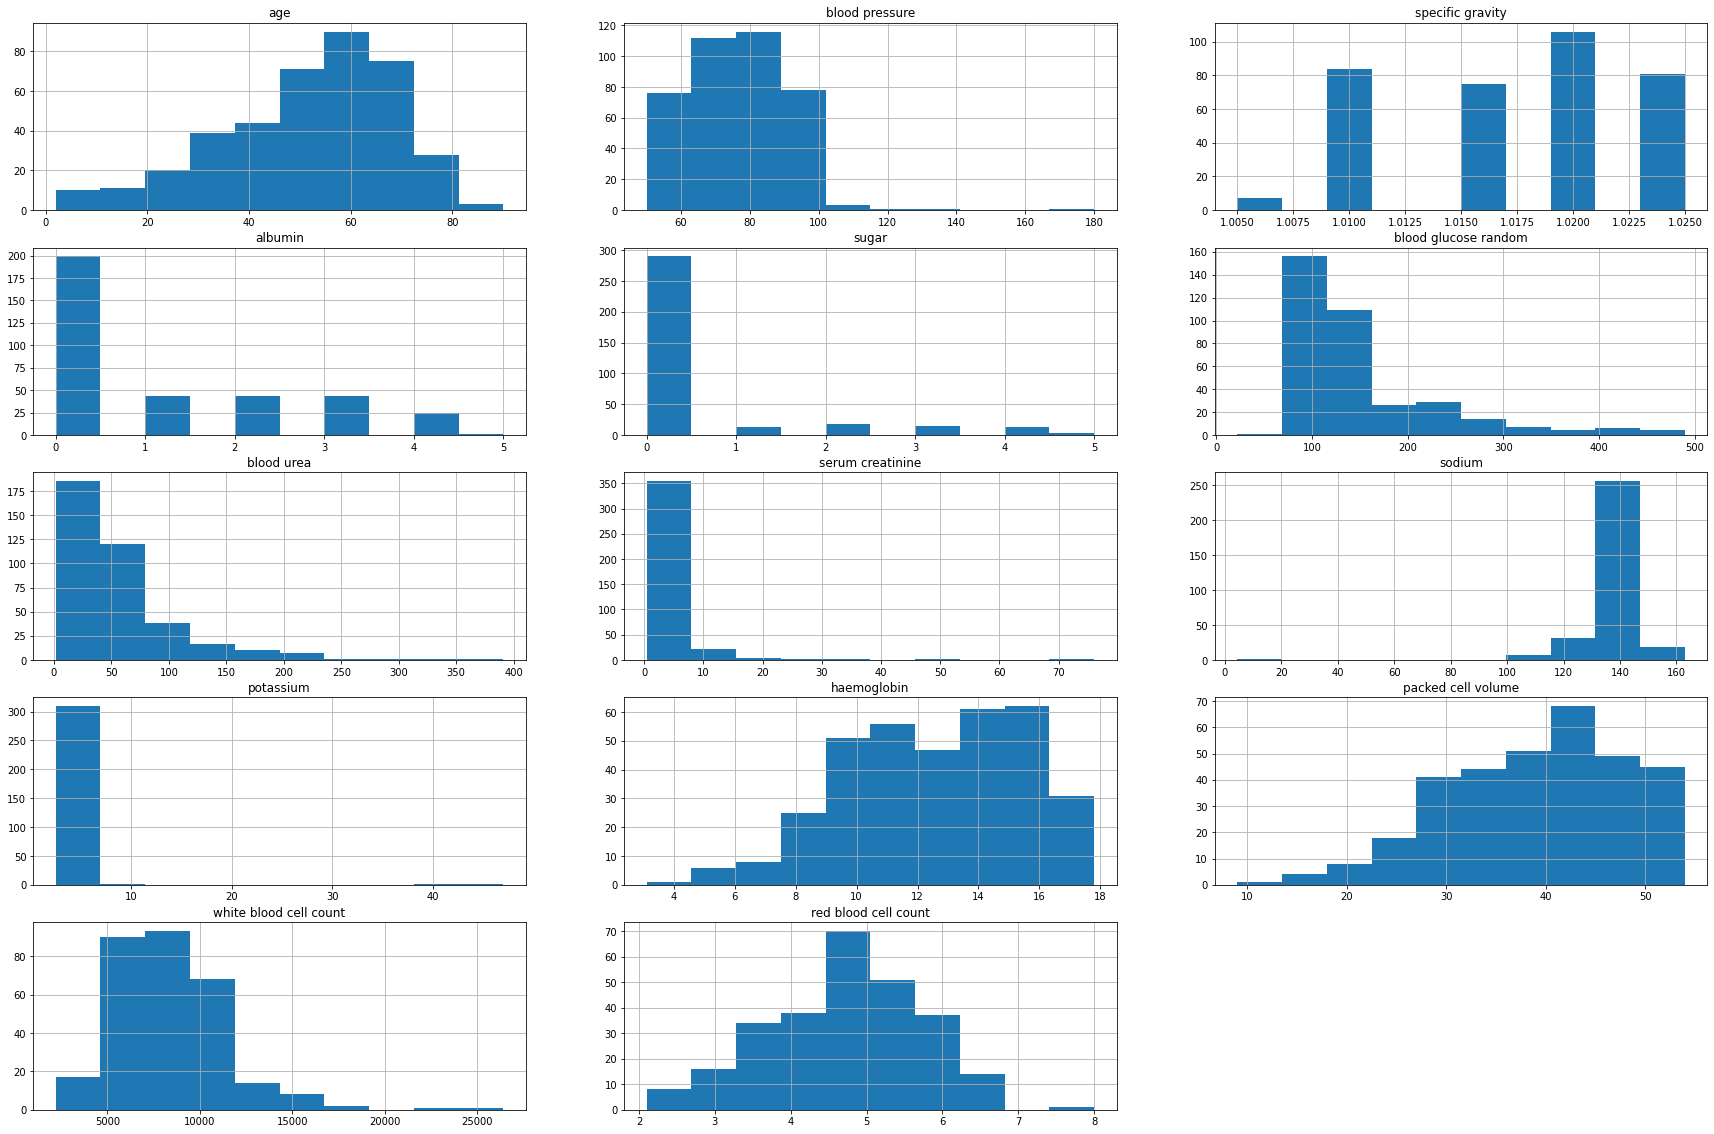

In [22]:
plt.figure(figsize=(30, 20))
for i, feature in enumerate(num_col):
  plt.subplot(5,3, i+1)
  df[feature].hist()
  plt.title(feature)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

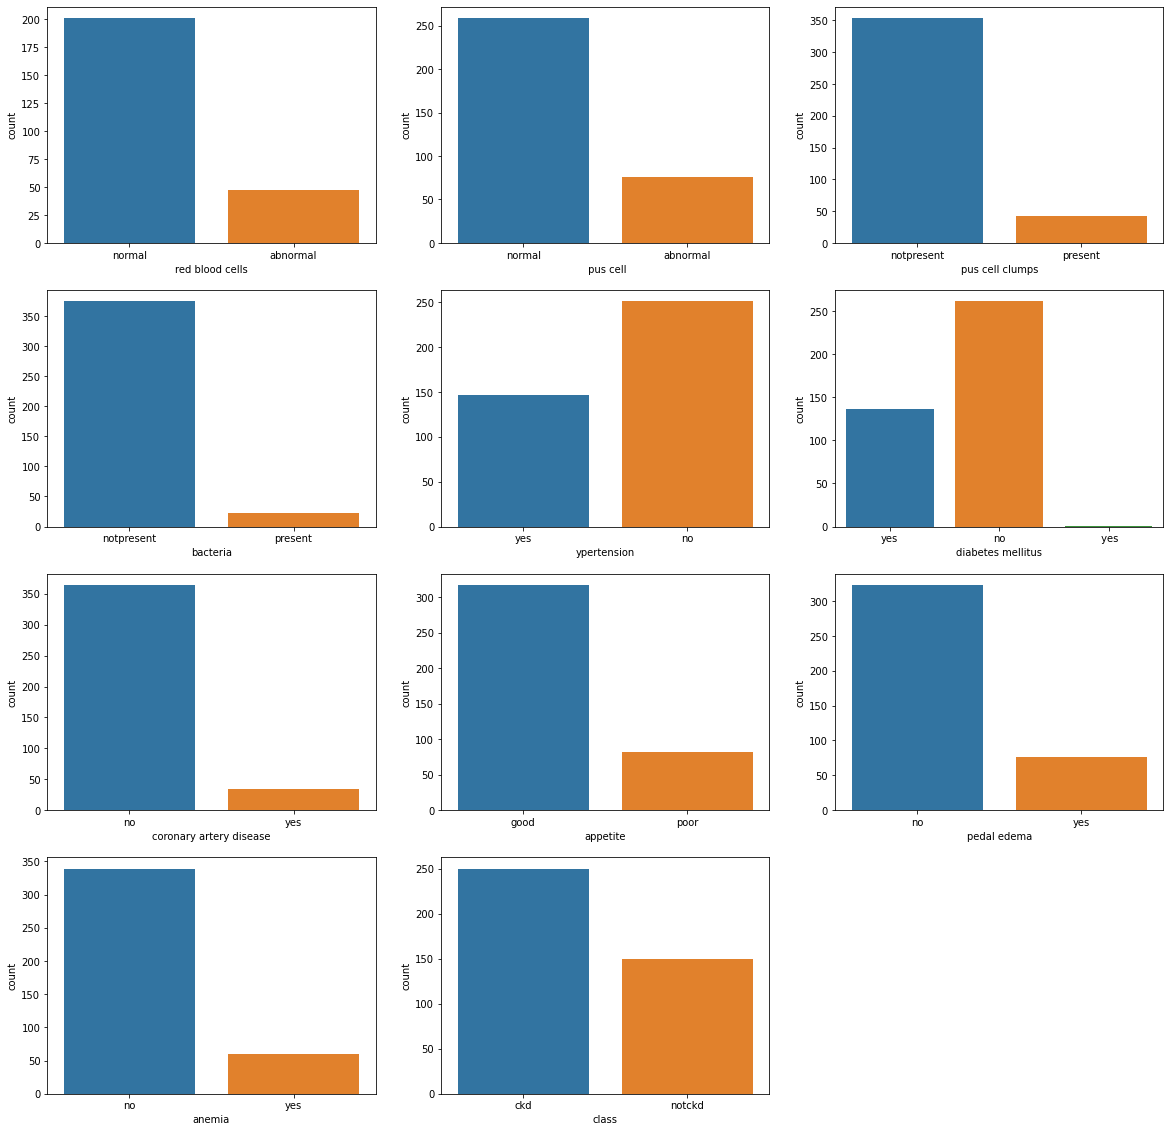

In [23]:
len(cat_col)
plt.figure(figsize= (20,20))
for i,feature in enumerate(cat_col):
  plt.subplot(4,3,i+1)
  sns.countplot(df[feature])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



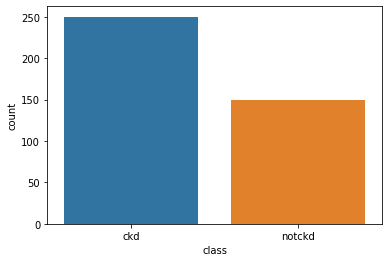

In [24]:
sns.countplot(df['class'])

Finding Co-relation within columns

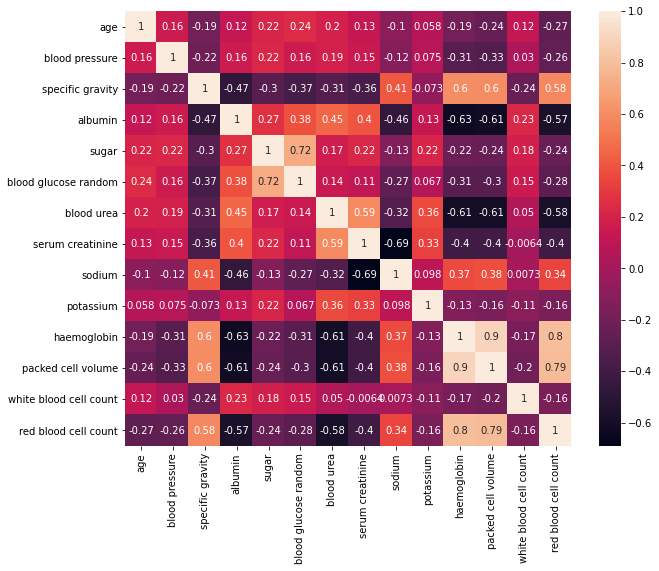

In [25]:
plt.figure(figsize=(10,8))
df.corr()
sns.heatmap(df.corr(), annot=True)

In [26]:
df.groupby(['red blood cells', 'class'])['red blood cell count'].agg(['count', 'mean', 'median', 'min', 'max'])

count      mean  median  min  max
red blood cells class                                    
abnormal        ckd        25  3.832000     3.7  2.5  5.6
normal          ckd        40  3.782500     3.8  2.1  8.0
                notckd    134  5.368657     5.3  4.4  6.5

In [27]:
px.violin(df, y='red blood cell count', x='class', color='class')

In [28]:
px.scatter(df, x='haemoglobin', y='packed cell volume')

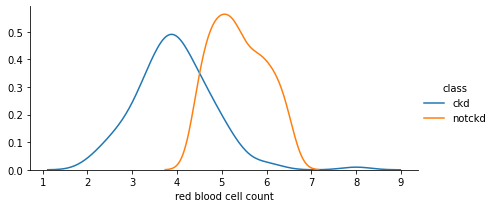

In [29]:
grid= sns.FacetGrid(df, hue='class', aspect=2)
grid.map(sns.kdeplot, 'red blood cell count')
grid.add_legend()

Automating the Analysis

In [30]:
def violin(col):
  fig= px.violin(df, y=col, x='class', color='class', box=True)
  return fig.show()

In [31]:
def scatters(col1, col2):
  fig= px.scatter(df, x=col1, y=col2, color='class')
  return fig.show()

In [32]:
def kde_plot(feature):
  grid= sns.FacetGrid(df, hue='class', aspect=2)
  grid.map(sns.kdeplot, feature)
  grid.add_legend()

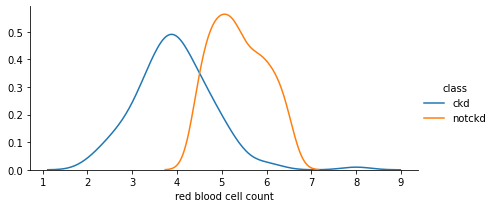

In [33]:
kde_plot('red blood cell count')

# Exploratory Data analysis

In [34]:
df.columns

Index(['age', 'blood pressure', 'specific gravity', 'albumin', 'sugar',
       'red blood cells', ' pus cell', 'pus cell clumps', 'bacteria',
       'blood glucose random', 'blood urea', 'serum creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed cell volume',
       'white blood cell count', 'red blood cell count', 'ypertension',
       'diabetes mellitus', 'coronary artery disease', 'appetite',
       'pedal edema', 'anemia', 'class'],
      dtype='object')

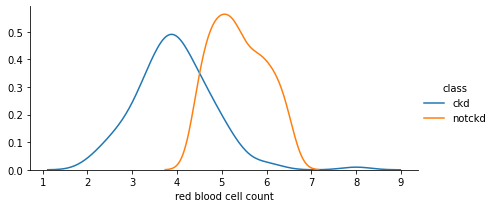

In [35]:
kde_plot('red blood cell count')

A person with chronic kidney disease usually has a lower RBC count than a person without a chronic kidney disease

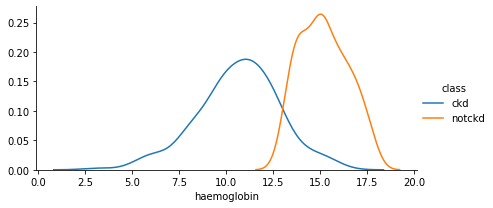

In [36]:
kde_plot('haemoglobin')

A person with chronic kidney disease usually has lower haemoglobin than a person without a chronic kidney disease

In [37]:
scatters('red blood cell count', 'packed cell volume')

People with chronic kidney disease almost follows a linear trend. People without that have non-linearity in the data

In [38]:
scatters('red blood cell count', 'haemoglobin')

People with chronic kidney disease almost follows a linear trend. People without that have non-linearity in the data. Similar to previous one

In [39]:
scatters('packed cell volume', 'haemoglobin')

People with chronic kidney disease almost follows a linear trend. People without that have non-linearity in the data. Similar to the two above. Moreover (almost) haemoglobin < 13 means chronic kidney disease. And that between 13 and 18 means no chronic kidney disease

In [40]:
violin('red blood cell count')

skewness in data for chronic kidney disease

In [41]:
violin('packed cell volume')

When RBC count is between 35 to 56 then there is a high probabilty that the person is negative for Chronic Kidney Disease. RBC count < 35 means huge probability for testing positive for Chronic Kidney Disease.

In [42]:
scatters('red blood cell count', 'albumin')

Albumin levels > 0 affect the chronic kidney disease largely. (increases the chances)

# Dealing with missing values

In [43]:
df.isna().sum().sort_values(ascending=False)

red blood cells            152
red blood cell count       131
white blood cell count     106
potassium                   88
sodium                      87
packed cell volume          71
 pus cell                   65
haemoglobin                 52
sugar                       49
specific gravity            47
albumin                     46
blood glucose random        44
blood urea                  19
serum creatinine            17
blood pressure              12
age                          9
bacteria                     4
pus cell clumps              4
ypertension                  2
diabetes mellitus            2
coronary artery disease      2
anemia                       1
appetite                     1
pedal edema                  1
class                        0
dtype: int64

We can fill the missing values with (1) Mean (2) Median (3) Standard Deviation (4) Random

For large ratios of missing values in dataset, mean negatively affects the prediction/ learning/ distribution

We have to maintain the distribution of the data distribution

We are going to fill random values to prevent change in ratio

In [44]:
df['red blood cells'].dropna().sample()

225    abnormal
Name: red blood cells, dtype: object

In [45]:
df['red blood cells'].isnull().sum()

152

In [46]:
random_sample=df['red blood cells'].dropna().sample(df['red blood cells'].isnull().sum())
random_sample

294      normal
357      normal
116    abnormal
239      normal
337      normal
         ...   
133      normal
292      normal
392      normal
7        normal
272      normal
Name: red blood cells, Length: 152, dtype: object

In [47]:
df[df['red blood cells'].isnull()].index

Int64Index([  0,   1,   5,   6,  10,  12,  13,  15,  16,  17,
            ...
            245, 268, 280, 290, 295, 309, 322, 349, 350, 381],
           dtype='int64', length=152)

In [48]:
random_sample.index

Int64Index([294, 357, 116, 239, 337, 308,  63, 363, 376, 330,
            ...
            341, 103, 176, 159, 155, 133, 292, 392,   7, 272],
           dtype='int64', length=152)

In [49]:
random_sample.index= df[df['red blood cells'].isnull()].index
random_sample.index

Int64Index([  0,   1,   5,   6,  10,  12,  13,  15,  16,  17,
            ...
            245, 268, 280, 290, 295, 309, 322, 349, 350, 381],
           dtype='int64', length=152)

In [50]:
random_sample

0        normal
1        normal
5      abnormal
6        normal
10       normal
         ...   
309      normal
322      normal
349      normal
350      normal
381      normal
Name: red blood cells, Length: 152, dtype: object

In [51]:
df.loc[df['red blood cells'].isnull(), 'red blood cells']= random_sample

In [52]:
df.head()

,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,serum creatinine,sodium,potassium,haemoglobin,packed cell volume,white blood cell count,red blood cell count,ypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [53]:
df['red blood cells'].isnull().sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



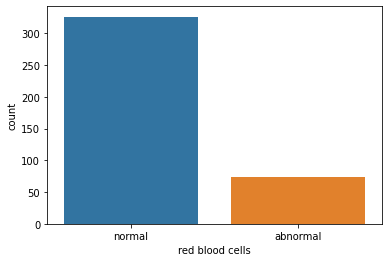

In [54]:
sns.countplot(df['red blood cells'])

Automating the task by creating a function

In [55]:
def Random_value_imputation(feature):
  random_sample= df[feature].dropna().sample(df[feature].isnull().sum())
  random_sample.index= df[df[feature].isnull()].index
  df.loc[df[feature].isnull(), feature]= random_sample

Filling up the missing values

In [56]:
for col in num_col:
  Random_value_imputation(col)

In [57]:
df[cat_col].isnull().sum()

red blood cells             0
 pus cell                  65
pus cell clumps             4
bacteria                    4
ypertension                 2
diabetes mellitus           2
coronary artery disease     2
appetite                    1
pedal edema                 1
anemia                      1
class                       0
dtype: int64

In [58]:
Random_value_imputation(' pus cell')

For less number we can use MODE

In [59]:
df['pus cell clumps'].mode()[0]

'notpresent'

Creating function to impute mode

In [60]:
def impute_mode(feature):
  mode= df[feature].mode()[0]
  df[feature]= df[feature].fillna(mode)

In [61]:
for col in cat_col:
  impute_mode(col)

In [62]:
df[cat_col].isnull().sum()

red blood cells            0
 pus cell                  0
pus cell clumps            0
bacteria                   0
ypertension                0
diabetes mellitus          0
coronary artery disease    0
appetite                   0
pedal edema                0
anemia                     0
class                      0
dtype: int64

# Feature Encoding

In [63]:
for col in cat_col:
  print('{} has {} unique categories'.format(col, df[col].nunique()))

red blood cells has 2 unique categories
 pus cell has 2 unique categories
pus cell clumps has 2 unique categories
bacteria has 2 unique categories
ypertension has 2 unique categories
diabetes mellitus has 3 unique categories
coronary artery disease has 2 unique categories
appetite has 2 unique categories
pedal edema has 2 unique categories
anemia has 2 unique categories
class has 2 unique categories


Label Encoding

(1) Normal is replaced with 0

(2) Abnormal is replaced with 1

(3) Anything else is replaced with 2

In [64]:
le= LabelEncoder()

In [65]:
for col in cat_col:
  df[col]= le.fit_transform(df[col])

In [66]:
df.head()

,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,serum creatinine,sodium,potassium,haemoglobin,packed cell volume,white blood cell count,red blood cell count,ypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.0,36.0,1.2,135.0,3.8,15.4,44.0,7800.0,5.2,1,2,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,99.0,18.0,0.8,136.0,6.6,11.3,38.0,6000.0,4.8,0,1,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,53.0,1.8,138.0,4.9,9.6,31.0,7500.0,4.2,0,2,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,1,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,26.0,1.4,136.0,5.0,11.6,35.0,7300.0,4.6,0,1,0,0,0,0,0


All categorical labels are now converted to numerical labels

# Selecting best features

In [67]:
ind_col= [col for col in df.columns if col!='class']
dep_col= 'class'

In [68]:
x= df[ind_col]
y= df[dep_col]

In [69]:
x.head()

,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,blood glucose random,blood urea,serum creatinine,sodium,potassium,haemoglobin,packed cell volume,white blood cell count,red blood cell count,ypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.0,36.0,1.2,135.0,3.8,15.4,44.0,7800.0,5.2,1,2,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,99.0,18.0,0.8,136.0,6.6,11.3,38.0,6000.0,4.8,0,1,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,53.0,1.8,138.0,4.9,9.6,31.0,7500.0,4.2,0,2,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,1,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,26.0,1.4,136.0,5.0,11.6,35.0,7300.0,4.6,0,1,0,0,0,0


In [70]:
y

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: class, Length: 400, dtype: int64

In [71]:
ordered_rank_features= SelectKBest(score_func= chi2, k=20)
ordered_feature= ordered_rank_features.fit(x,y)

In [72]:
ordered_feature

SelectKBest(k=20, score_func=<function chi2 at 0x7f528afb0200>)

In [73]:
ordered_feature.scores_

array([1.17315634e+02, 7.45966754e+01, 5.23771912e-03, 2.29768977e+02,
       1.06800000e+02, 8.67811861e+00, 1.55463203e+01, 2.52000000e+01,
       1.32000000e+01, 2.53725416e+03, 2.29186701e+03, 3.26854556e+02,
       3.44595579e+01, 3.04847985e+00, 1.16966024e+02, 3.51176391e+02,
       1.31984632e+04, 2.22159211e+01, 8.82000000e+01, 2.04392523e+01,
       2.04000000e+01, 4.92000000e+01, 4.56000000e+01, 3.60000000e+01])

In [74]:
datascores= pd.DataFrame(ordered_feature.scores_, columns=['Score'])

In [75]:
datascores

,Score
0,117.315634
1,74.596675
2,0.005238
3,229.768977
4,106.800000
5,8.678119
6,15.546320
7,25.200000
8,13.200000
9,2537.254161


In [76]:
dfcols= pd.DataFrame(x.columns)
dfcols

,0
0,age
1,blood pressure
2,specific gravity
3,albumin
4,sugar
5,red blood cells
6,pus cell
7,pus cell clumps
8,bacteria
9,blood glucose random


In [77]:
features_rank=pd.concat([dfcols, datascores], axis= 1)

In [78]:
features_rank

,0,Score
0,age,117.315634
1,blood pressure,74.596675
2,specific gravity,0.005238
3,albumin,229.768977
4,sugar,106.800000
5,red blood cells,8.678119
6,pus cell,15.546320
7,pus cell clumps,25.200000
8,bacteria,13.200000
9,blood glucose random,2537.254161


In [79]:
features_rank.columns= ['features', 'Score']
features_rank

,features,Score
0,age,117.315634
1,blood pressure,74.596675
2,specific gravity,0.005238
3,albumin,229.768977
4,sugar,106.800000
5,red blood cells,8.678119
6,pus cell,15.546320
7,pus cell clumps,25.200000
8,bacteria,13.200000
9,blood glucose random,2537.254161


In [80]:
features_rank.nlargest(10, 'Score')

,features,Score
16,white blood cell count,13198.463180
9,blood glucose random,2537.254161
10,blood urea,2291.867005
15,packed cell volume,351.176391
11,serum creatinine,326.854556
3,albumin,229.768977
0,age,117.315634
14,haemoglobin,116.966024
4,sugar,106.800000
18,ypertension,88.200000


In [81]:
selected_columns= features_rank.nlargest(10, 'Score')['features'].values

In [82]:
selected_columns

array(['white blood cell count', 'blood glucose random', 'blood urea',
       'packed cell volume', 'serum creatinine', 'albumin', 'age',
       'haemoglobin', 'sugar', 'ypertension'], dtype=object)

In [83]:
x_new= df[selected_columns]
x_new.head()

,white blood cell count,blood glucose random,blood urea,packed cell volume,serum creatinine,albumin,age,haemoglobin,sugar,ypertension
0,7800.0,121.0,36.0,44.0,1.2,1.0,48.0,15.4,0.0,1
1,6000.0,99.0,18.0,38.0,0.8,4.0,7.0,11.3,0.0,0
2,7500.0,423.0,53.0,31.0,1.8,2.0,62.0,9.6,3.0,0
3,6700.0,117.0,56.0,32.0,3.8,4.0,48.0,11.2,0.0,1
4,7300.0,106.0,26.0,35.0,1.4,2.0,51.0,11.6,0.0,0


In [84]:
len(x_new)

400

In [85]:
x_new.shape

(400, 10)

# The Model

In [86]:
X_train, X_test, y_train, y_test= train_test_split(x_new, y, random_state=0, test_size= 0.25)

In [87]:
print(X_train.shape)

(300, 10)


In [88]:
print(X_test.shape)

(100, 10)


In [89]:
y_train.value_counts()

0    188
1    112
Name: class, dtype: int64

In [90]:
XGBClassifier()
classifier= XGBClassifier()

In [91]:
params={
    'learning_rate': [0.05,0.20,0.25],
    'max_depth': [5, 8, 10],
    'min_child_weight': [1,3,5,7],
    'gamma': [0.0, 0.1, 0.2, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.7]
}

In [92]:
random_search= RandomizedSearchCV(classifier, param_distributions= params, n_iter=5, scoring='roc_auc', n_jobs= -1, cv= 5, verbose= 3)

In [93]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_i

In [94]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [95]:
random_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 3}

In [96]:
classifier= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [97]:
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [98]:
y_pred= classifier.predict(X_test)

In [99]:
y_pred

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1])

In [100]:
confusion_matrix(y_test, y_pred)

array([[58,  4],
       [ 2, 36]])

In [101]:
accuracy_score(y_test, y_pred)

0.94